In [87]:
from matplotlib import image
from matplotlib import pyplot as plt

In [88]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [90]:
from sklearn.neighbors import KNeighborsClassifier


In [91]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr

In [92]:
import random

In [93]:
from tqdm import tqdm

In [94]:
import pandas as pd

In [95]:
from sklearn import model_selection, metrics

In [96]:
%run technical_functions/cv_and_reclassification_methods.ipynb

In [97]:
%run technical_functions/functions_geotransforms.ipynb

Работаем с тензором признаков SRDM-матрицы.

In [190]:
T = np.load('properties_55/SRDM_properties_55.npy')

In [191]:
T.shape

(424, 448, 4)

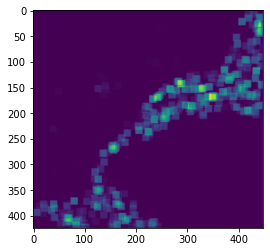

In [192]:
plt.imshow(T[:, :, 0])

In [194]:
for i in range(4):
    print(np.max(T[:, :, i]), np.min(T[:, :, i]), i)


6.766590248695204 0.0 0
1.5552740390922208 0.0 1
14.350941611479236 0.0 2
3.0228828166378 0.0 3


Сейчас будем загружать карту. 

In [151]:
map_konst = gdal.Open('Konstantinovsky_map.tif')
konstantinovsky_mult = rxr.open_rasterio("geotiff/Konstantinovky_TestReg_mult.tif")
konstantinovsky_mult_gdal = gdal.Open("geotiff/Konstantinovky_TestReg_mult.tif")
map_konst_rasterio = rxr.open_rasterio("Konstantinovsky_map.tif").squeeze()

m_m, m_n = konstantinovsky_mult.shape[1], konstantinovsky_mult.shape[2]
geo_trans_mult = konstantinovsky_mult_gdal.GetGeoTransform()
proj_mult = konstantinovsky_mult_gdal.GetProjection()
geo_trans_pan = map_konst.GetGeoTransform()
proj_pan = map_konst.GetProjection()
pixels_pan_list = []
for i in range(1, m_m + 1):
    a = []
    for j in range(1, m_n + 1):
        a.append((i, j))
    a_coords = pix2coord(a, geo_trans_mult, proj_mult) #были пиксели в мультиканальном, стали координаты
    a_pixels_in_pan = coord2pix(a_coords, geo_trans_pan, proj_pan)
    pixels_pan_list.append(a_pixels_in_pan)
    
map_konst_ = np.zeros((T.shape[0], T.shape[1]))
cnt_i = 0
cnt_j = 0
for line in tqdm(pixels_pan_list):
    cnt_j = 0
    for elem in line:
        i, j = elem
        i = int(i - 1)
        j = int(j - 1)
        map_konst_[cnt_i][cnt_j] = map_konst_rasterio.values[i][j]
        cnt_j += 1
    cnt_i += 1

100%|███████████████████████████████████████████████████████████████████████████████| 424/424 [00:02<00:00, 149.24it/s]


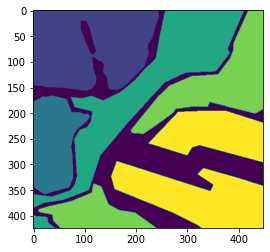

In [152]:
plt.imshow(map_konst_)

In [153]:
map_konst_.shape

(424, 448)

In [166]:
import skimage.io
import skimage.filters

sigma = 7.0
for i in range(4):
    T[:, :, i] = skimage.filters.gaussian(
        T[:, :, i], sigma=(sigma, sigma), truncate=3.5, multichannel=False)

In [167]:
X = []
y = []
cnt = np.zeros(5)
for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
            X.append(T[i, j, :])
            y.append(map_konst_[i, j])
            cnt[int(map_konst_[i][j])- 1] += 1

In [168]:
X = np.array(X)
y = np.array(y)

In [185]:
arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=0, stratify = arr)

In [186]:
qda = QuadraticDiscriminantAnalysis()

In [187]:
qda.fit(X_train, y_train)

C:\Users\abazarova\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [188]:
pred_qda = qda.predict(T.reshape(424 * 448, 4))

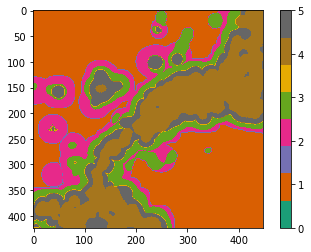

In [189]:
plt.imshow(pred_qda.reshape(T.shape[0], T.shape[1]), cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()

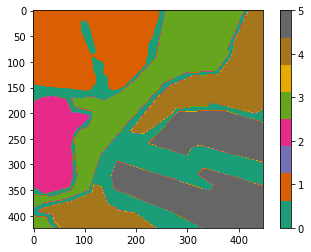

In [29]:
plt.imshow(map_konst_, cmap=plt.get_cmap('Dark2'))
plt.colorbar()

In [162]:
q = QuadraticDiscriminantAnalysis()
mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
mt[3]

C:\Users\abazarova\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\abazarova\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\abazarova\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\abazarova\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\abazarova\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\abazarova\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\U

[                  10-fold cross-validation
                                      Value
 Accuracy                          0.836752
 Kappa Coefficient                 0.795929,
                   Reclassification
                              Value
 Accuracy                  0.845774
 Kappa Coefficient         0.807213]

Видим, что получилась какая-то дрянь. Возможно, причина в зависимости признаков. Попробуем выбирать признаки поочередно.

In [30]:
accuracy_arr_1_layer = []
for t in tqdm(range(4)):
    T_layer0 = T[:, :, t]
    X = []
    y = []
    cnt = np.zeros(5)
    for i in range(T_layer0.shape[0]):
        for j in range(T_layer0.shape[1]):
            if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
                X.append(T_layer0[i, j])
                y.append(map_konst_[i, j])
                cnt[int(map_konst_[i][j])- 1] += 1
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((-1, 1))
    arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
    q = QuadraticDiscriminantAnalysis()
    mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
    accuracy_arr_1_layer.append((t, mt[3][0].values[0]))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/it]


In [31]:
accuracy_arr_1_layer

[(0, array([0.61114787])),
 (1, array([0.61182957])),
 (2, array([0.62147703])),
 (3, array([0.61612364]))]

In [32]:
T_layer0 = T[:, :, 2]
X = []
y = []
cnt = np.zeros(5)
for i in range(T_layer0.shape[0]):
    for j in range(T_layer0.shape[1]):
        if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
            X.append(T_layer0[i, j])
            y.append(map_konst_[i, j])
            cnt[int(map_konst_[i][j])- 1] += 1
X = np.array(X)
y = np.array(y)
X = X.reshape((-1, 1))
arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
pred_qda = qda.predict(T_layer0.reshape(424 * 448, 1))

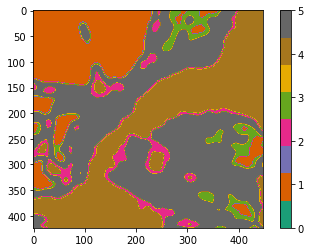

In [33]:
plt.imshow(pred_qda.reshape(T.shape[0], T.shape[1]), cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()

Наибольшую accuracy дает 2 слой. Будем поочередно пробовать добавлять к нему другие слои.

In [35]:
accuracy_arr_2_layers = []
for t in tqdm(range(4)):
    if t != 2:
        T_layer1 = np.stack((T_layer0, T[:, :, t]), axis = 2)
        X = []
        y = []
        cnt = np.zeros(5)
        for i in range(T_layer1.shape[0]):
            for j in range(T_layer1.shape[1]):
                if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
                    X.append(T_layer1[i, j])
                    y.append(map_konst_[i, j])
                    cnt[int(map_konst_[i][j])- 1] += 1
        X = np.array(X)
        y = np.array(y)
        arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
        q = QuadraticDiscriminantAnalysis()
        mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
        accuracy_arr_2_layers.append((t, mt[3][0].values[0]))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.20s/it]


In [36]:
accuracy_arr_2_layers

[(0, array([0.65436926])), (1, array([0.69110109])), (3, array([0.69584962]))]

In [38]:
T_layer1 = np.stack((T_layer0, T[:, :, 3]), axis = 2)
X = []
y = []
cnt = np.zeros(5)
for i in range(T_layer1.shape[0]):
    for j in range(T_layer1.shape[1]):
        if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
            X.append(T_layer1[i, j])
            y.append(map_konst_[i, j])
            cnt[int(map_konst_[i][j])- 1] += 1
X = np.array(X)
y = np.array(y)
arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
pred_qda = qda.predict(T_layer1.reshape(424 * 448, 2))

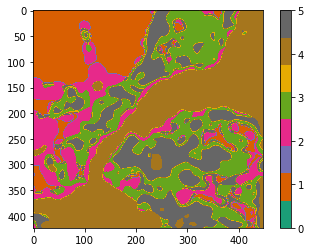

In [39]:
plt.imshow(pred_qda.reshape(T.shape[0], T.shape[1]), cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()

In [40]:
accuracy_arr_3_layers = []
for t in tqdm(range(4)):
    if t != 2 and t != 3:
        T_layer2 = np.stack((T[:, :, 2], T[:, :, 3], T[:, :, t]), axis = 2)
        X = []
        y = []
        cnt = np.zeros(5)
        for i in range(T_layer2.shape[0]):
            for j in range(T_layer2.shape[1]):
                if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
                    X.append(T_layer2[i, j])
                    y.append(map_konst_[i, j])
                    cnt[int(map_konst_[i][j])- 1] += 1
        X = np.array(X)
        y = np.array(y)
        arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
        q = QuadraticDiscriminantAnalysis()
        mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
        accuracy_arr_3_layers.append((t, mt[3][0].values[0]))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]


In [41]:
accuracy_arr_3_layers

[(0, array([0.86996157])), (1, array([0.86997828]))]

In [42]:
T_layer3 = np.stack((T[:, :, 2], T[:, :, 3], T[:, :, 1]), axis = 2)
X = []
y = []
cnt = np.zeros(5)
for i in range(T_layer3.shape[0]):
    for j in range(T_layer3.shape[1]):
        if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
            X.append(T_layer3[i, j])
            y.append(map_konst_[i, j])
            cnt[int(map_konst_[i][j])- 1] += 1
X = np.array(X)
y = np.array(y)
arr = [1] * 9500 + [2] * 9500 + [3] * 9500 + [4] * 9500 + [5] * 9500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = arr)
q = QuadraticDiscriminantAnalysis()
q.fit(X_train, y_train)
pred_qda = q.predict(T_layer3.reshape(424 * 448, 3))

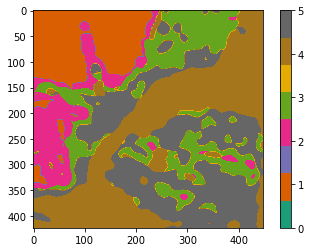

In [43]:
plt.imshow(pred_qda.reshape(T.shape[0], T.shape[1]), cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()